<a href="https://colab.research.google.com/github/reetibhagat/Capstone-project2/blob/master/Pneumonia_Detection_using_Transfer_learning_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;font-size: 40px;">Pneumonia Detection from Chest X-Ray images</h1>

---

<center><img src="https://www.drugs.com/health-guide/images/022dc126-fc5d-4e54-9a78-75f2c9ea4bb6.jpg
"width="500" height="600"></center>


><h3>What is Pneumonia??</h3>

>> Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

><h3>Symptoms</h3>

>> The signs and symptoms of pneumonia vary from mild to severe, depending on factors such as the type of germ causing the infection, and your age and overall health. Mild signs and symptoms often are similar to those of a cold or flu, but they last longer.

Signs and symptoms of pneumonia may include:

- Chest pain when you breathe or cough
- Confusion or changes in mental awareness (in adults age 65 and older)
- Cough, which may produce phlegm
- Fatigue
- Fever, sweating and shaking chills
- Lower than normal body temperature (in adults older than age 65 and people with weak immune systems)
- Nausea, vomiting or diarrhea
- Shortness of breath

Newborns and infants may not show any sign of the infection. Or they may vomit, have a fever and cough, appear restless or tired and without energy, or have difficulty breathing and eating.

Today we are going to apply transfer learning VGG-16model on X-Ray images of chest. Dataset is imbalanced (approx. 1:3), images may have different site and can have one or 3 color channels.

At start, we will preprocess our data in very simple and intuitive way (load, resize, create labels and use VGG-16 model.



In [1]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls '/content/drive/My Drive/capstone_2/chest_xray/'

chest_xray  __MACOSX  test  train  val


In [3]:
!ls '/content/drive/My Drive/capstone_2/chest_xray/chest_xray/'

test  train  val


## Importing packages

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import random as rn
import seaborn as sns
import cv2
import random
#import pandas.util.testing as tm
import glob

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.optimizers import RMSprop ,Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
#
import os
print(os.listdir('/content/drive/My Drive/capstone_2/chest_xray/chest_xray/'))

['.DS_Store', 'train', 'test', 'val']


In [5]:
# assigning variables with the proper file path for the training, validation and test set
data_path= '/content/drive/My Drive/capstone_2/chest_xray/chest_xray/'

train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')

In [6]:
os.listdir(train_dir)

['.DS_Store', 'NORMAL', 'PNEUMONIA']

In [ ]:
alltype = ["NORMAL","PNEUMONIA"]
normal = random.sample(os.listdir(train_dir+"/NORMAL"),5)
pneumonia = random.sample(os.listdir(train_dir+"/PNEUMONIA"),5)


 ## Visualization of images

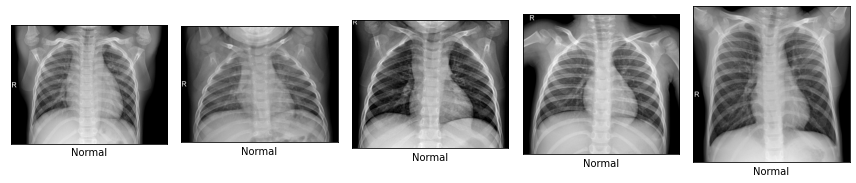

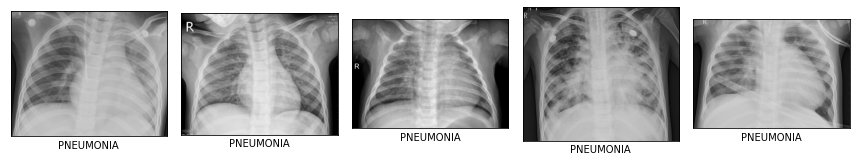

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.set_size_inches(12,12)

for i,image in enumerate(normal):
    plt.subplot(1,5,i+1)
    img = load_img(train_dir+"/NORMAL"+"/"+image)
    plt.imshow(img)
    plt.xlabel("Normal")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout();

plt.figure(figsize=(12,6))
fig.set_size_inches(12,12)

for i,image in enumerate(pneumonia):
    plt.subplot(1,5,i+1)
    img = load_img(train_dir+"/PNEUMONIA"+"/"+image)
    plt.imshow(img)
    plt.xlabel("PNEUMONIA")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [ ]:
print("Total images in Train directory: {}".format(len(os.listdir(train_dir+"/NORMAL")) + len(os.listdir(train_dir+"/PNEUMONIA"))))
print("Total images in Test directory: {}".format(len(os.listdir(test_dir+"/NORMAL")) + len(os.listdir(test_dir+"/PNEUMONIA"))))
print("Total images in Validation directory: {}".format(len(os.listdir(val_dir+"/NORMAL")) + len(os.listdir(val_dir+"/PNEUMONIA"))))

Total images in Train directory: 5218
Total images in Test directory: 624
Total images in Validation directory: 18


## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tr_datagen = ImageDataGenerator(rescale=(1/255.),shear_range = 0.2,zoom_range=0.3,horizontal_flip=True,
                                fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = (1/255.))

train_datagen = tr_datagen.flow_from_directory(directory = train_dir,target_size=(150,150),
                                               class_mode = "binary",batch_size=32)
valid_datagen = val_datagen.flow_from_directory(directory = val_dir,target_size=(150,150),
                                                class_mode = "binary",batch_size=4)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Model Building

### Transfer Learning

Here i'm going to use Transfer learning model VGG16.VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.


<center><img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16.png
"width="700" height="600"></center>


> <h3>Architecture:</h3>

<center><img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg
"width="700" height="600"></center>

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg=VGG16(
include_top=False,
weights="imagenet",
input_tensor=None,
input_shape=(150,150,3),
classes=1000,
)

In [ ]:
for layer in vgg.layers:
    layer.trainable =False

In [ ]:
# adding layers
x=vgg.output
x=Flatten()(x)
x=Dense(units=4096,activation="relu")(x)
x=BatchNormalization()(x)
x=Dropout(0.4)(x)

predictions=Dense(units=1,activation='sigmoid')(x)

In [ ]:
#Compile the model
model=Model(inputs=vgg.input,outputs=predictions)
model.compile(optimizer='Adam',loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

In [ ]:
#fitting the model

history=model.fit_generator(
    generator=train_datagen,
    steps_per_epoch=len(train_datagen),
    epochs=15,
    verbose=1,
    validation_data=valid_datagen,
    validation_steps=len(valid_datagen)
)

Epoch 1/15
163/163 [==============================] - 503s 3s/step - loss: 0.2245 - accuracy: 0.9210 - val_loss: 1.9521 - val_accuracy: 0.5625
Epoch 2/15
163/163 [==============================] - 470s 3s/step - loss: 0.1753 - accuracy: 0.9387 - val_loss: 0.5368 - val_accuracy: 0.7500
Epoch 3/15
163/163 [==============================] - 385s 2s/step - loss: 0.1530 - accuracy: 0.9431 - val_loss: 0.6941 - val_accuracy: 0.7500
Epoch 4/15
163/163 [==============================] - 396s 2s/step - loss: 0.1519 - accuracy: 0.9433 - val_loss: 0.3889 - val_accuracy: 0.8125
Epoch 5/15
163/163 [==============================] - 392s 2s/step - loss: 0.1453 - accuracy: 0.9456 - val_loss: 1.3517 - val_accuracy: 0.6250
Epoch 6/15
163/163 [==============================] - 397s 2s/step - loss: 0.1408 - accuracy: 0.9484 - val_loss: 0.5785 - val_accuracy: 0.6250
Epoch 7/15
163/163 [==============================] - 395s 2s/step - loss: 0.1366 - accuracy: 0.9477 - val_loss: 0.1061 - val_accuracy: 0.9375

In [ ]:
#evaluate the model
test_loss, test_acc = model.evaluate_generator(valid_datagen, steps=2)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


Test accuracy: 1.0
Test loss: 0.14112666249275208


In [ ]:
# TESTING DATA
test_datagen=ImageDataGenerator(rescale=(1/255.))
test_data=test_datagen.flow_from_directory(directory=test_dir,
                                          target_size=(150,150),
                                          class_mode='binary',
                                          batch_size=32
                                          )

Found 624 images belonging to 2 classes.


In [ ]:
# Test your model on unknown samples (testing data)
test_loss, test_acc = model.evaluate_generator(test_data, steps=16)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 0.888671875
Test loss: 0.2511751055717468


## Learning Curve

In [ ]:
plt.style.use("seaborn")
def plot_learning_curve(history,epochs):
    epochs=np.arange(epochs+1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuarcy")
    plt.legend(["Train","val"],loc="upper left")
    plt.show()
    
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train","val"],loc="upper left")
    plt.show()
    
    

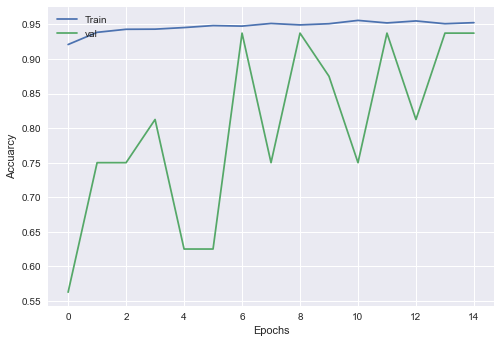

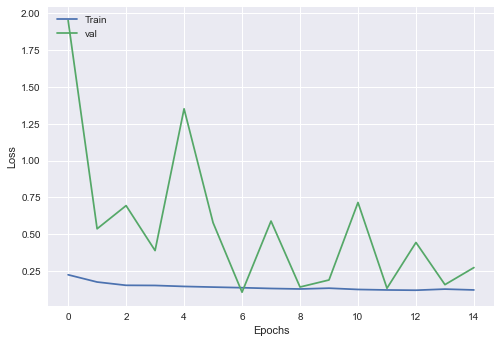

In [ ]:
plot_learning_curve(history,15)

In [ ]:
## testing data on model

In [ ]:
import cv2
import numpy as np
from collections import Counter
img_height = 150
img_width = 150


# making predictions off of the test set 
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(data_path + 'test' + cond)):
        img = plt.imread(data_path +'test'+ cond + img)
        img = cv2.resize(img, (img_height, img_width))
        img = np.dstack([img, img, img]) #concatenates along the third dimension
        img = img.astype('float32') / 255
        if cond =='/NORMAL/':
            label = 0
        elif cond =='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)
    
print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", Counter(test_labels))

Total number of test examples:  (624, 150, 150, 3)
Total number of labels: Counter({1: 390, 0: 234})


In [ ]:
import seaborn as sns
# creating a function that plots the confusion matrix
def conf_matrix(conf_mat):
    labels = ['NORMAL', 'PNEUMONIA']
    ax=sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels,
                   annot=True, fmt='d', cmap="Blues")
    ax.set_title('Confusion Matrix')


In [ ]:

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       234
           1       0.92      0.92      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



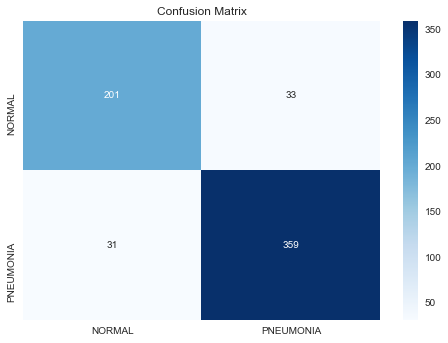

In [ ]:
# calling the confusion matrix    
conf_matrix(cm)

print(classification_report(test_labels, np.round(preds)))

Notice how the confusion matrix changed from other notebook and became even better than before.

In [ ]:
359/(359+33)

0.9158163265306123

This model even has greater precision than before . Earlier the precision was 87 % but now it is having 91.58 % as its precision . Therefore I have minimized false positive in the denominator of the formula . This will even make more sure than before that a person not suffering from pneumonia shouldn't be diagnosed as being suffering from pneumonia. This is what precision is .

In [ ]:
359/(359+31)

0.9205128205128205

The recall for the above trained model is approx. 92 % which is less than another model . Also as I told in other notebook more priority is to given to recall when compare to precision for this dataset.¶